# [Ateliers: Technologies de l'intelligence Artificielle](https://github.com/wikistat/AI-Frameworks)

<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" width=400, style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# Traitement Naturel du Langage (NLP) : Catégorisation de Produits Cdiscount

Il s'agit d'une version simplifiée du concours proposé par Cdiscount et paru sur le site [datascience.net](https://www.datascience.net/fr/challenge). Les données d'apprentissage sont accessibles sur demande auprès de Cdiscount mais les solutions de l'échantillon test du concours ne sont pas et ne seront pas rendues publiques. Un échantillon test est donc construit pour l'usage de ce tutoriel.  L'objectif est de prévoir la catégorie d'un produit à partir de son descriptif (*text mining*). Seule la catégorie principale (1er niveau, 47 classes) est prédite au lieu des trois niveaux demandés dans le concours. L'objectif est plutôt de comparer les performances des méthodes et technologies en fonction de la taille de la base d'apprentissage ainsi que d'illustrer sur un exemple complexe le prétraitement de données textuelles. 

Le jeux de données complet (15M produits) permet un test en vrai grandeur du **passage à l'échelle volume** des phases de préparation (*munging*), vectorisation (hashage, TF-IDF) et d'apprentissage en fonction de la technologie utilisée.

La synthèse des résultats obtenus est développée par [Besse et al. 2016](https://hal.archives-ouvertes.fr/hal-01350099) (section 5).

## Partie 1 : Exploration et Nettoyage de données textuelles

Dans ce premier notebook nous verrons différent traitements généralement opérés sur des données textuelles :

* **Nettoyage** : Suppression des caractères mal codés et de ponctuation, transformation des majuscules en minuscules, en remarquant que ces transformations ne seraient pas pertinentes pour un objectif de détection de pourriels.
* **StopWord** : Suppression des mots inutiles ou mots de liaison, articles qui n'ont a priori pas de pouvoir discriminant.
* **Stemming** (ou Racinisation): Les mots sont réduits à leur seule racine afin de réduire la taille du dictionnaire.

## Librairies

In [1]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import re 
import collections
import itertools
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

import sklearn.cross_validation as scv

**nltk**

Si vous utilisez la librairie `nltk` pour la première fois, il est nécessaire d'utiliser la commande suivante. Cette commande permet de télécharger de nombreux corpus de texte, mais également des informations grammaticales sur différentes langues. Information notamment nécessaire à l'étape de racinisation.

In [2]:
# nltk.download("all")

## Les données

Dans le dossier *Cdiscount/data* de ce répértoire vous trouverez les fichiers suivants :

* `cdiscount_test.csv.zip`: Fichier d'apprentissage constitué de 1.000.000 de lignes
* `cdisount_test`: Fichier test constitué de 50.000 lignes


   ### Read & Split Dataset
   
   On définit une fonction permettant de lire le fichier d'apprentissage et de créer deux DataFrame Pandas, un pour l'apprentissage, l'autre pour la validation.
   La fonction créée un DataFrame en lisant entièrement le fichier. Puis elle scinde ce DataFrame en deux grâce à la fonction dédiée de sklearn. 

In [3]:
def split_dataset(input_path, nb_line, tauxValid):
    data_all = pd.read_csv(input_path,sep=",", nrows=nb_line)
    data_all = data_all.fillna("")
    data_train, data_valid = scv.train_test_split(data_all, test_size = tauxValid)
    time_end = time.time()
    return data_train, data_valid

Bien que déjà réduit par rapport au fichier original du concours, contenant plus de 15M de lignes, le fichier cdiscount_test.csv.zip, contenant 1M de lignes est encore volumineux. 
Nous allons charger en mémoire qu'une partie de ce fichier grace à l'argument `nb_line` afin d'éviter des temps de calcul trop couteux. 
Nous allons extraire 5% de ces 1M de lignes commes échantillons de validation.

In [4]:
input_path = "data/cdiscount_train.csv.zip"
nb_line=100000  # part totale extraite du fichier initial ici déjà réduit
tauxValid = 0.05
data_train, data_valid = split_dataset(input_path, nb_line, tauxValid)
# Cette ligne permet de visualiser les 5 premières lignes de la DataFrame 
N_train = data_train.shape[0]
N_valid = data_valid.shape[0]
print("Train set : %d elements, Validation set : %d elements" %(N_train, N_valid))

Train set : 95000 elements, Validation set : 5000 elements


La commande suivante permet d'afficher les premières lignes du fichiers. 

Vous pouvez observer que chaque produit possède 3 niveaux de Catégories, qui correspondent au différents niveaux de l'arborescence que vous retrouverez sur le site.
Il y a 44 catégories de niveau 1, 428 de niveau 2 et 3170 de niveau 3. 

Dans ce TP, nous nous interesserons uniquement à classer les produits dans la catégorie de niveau 1.

In [5]:
data_train.head(5)

,Categorie1,Categorie2,Categorie3,Description,Libelle,Marque
67877,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,BATTERIE TELEPHONE,Batterie Originale B100AE pour SAMSUNG GT-S722...,Batterie Originale B100AE pour SAMSUNG GT-S722...,SAMSUNG
76807,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque souple Rose pour WIKO IGGY motif Drapeau...,Coque souple Rose pour WIKO IGGY motif Drapeau …,MUZZANO
92601,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,OREILLETTE - KIT VOITURE BLUETOOTH TELEPHONE,Motorola - Oreillette H720 - Motorola - Oreill...,Motorola - Oreillette H720,MOTOROLA
64737,LIBRAIRIE,AUTRES LIVRES,AUTRES LIVRES,De Collectif aux éditions HARRAP'S,Harrap's petit dictionnaire,
75910,AUTO - MOTO (NEW),CONFORT CONDUCTEUR ET PASSAGER,KIT D'INSTALLATION D'AUTORADIO,CA-R-PI.131. Interface commande au volant pour...,CA-R-PI.131. Interface commande au volant pour...,AUCUNE


La commande suivante permet d'afficher un exemple de produits pour chaque Catégorie de niveau 1.

In [6]:
data_train.groupby("Categorie1").first()[["Description","Libelle","Marque"]]

,Description,Libelle,Marque
Categorie1,,,
ADULTE - EROTIQUE,EJACS / DELUGE DE SPERME / BUVEUSE DE SPERME /...,Die Spermaschwerstern,AUCUNE
ANIMALERIE - NEW,ROYAL CANIN Canine Dental Special < 10 kg DSD2...,"ROYAL CANIN Canine Dental <10kg DSD25 3,5kg",ROYAL CANIN
ARME DE COMBAT - ARME DE SPORT,Barillet pour RUGER SUPER HAWK CO2 en pack de 5.,Barillets RUGER SUPER HAWK X5,UMAREX
ART DE LA TABLE - ARTICLES CULINAIRES,Vous allez adorer ces 4 bols aux motifs à la ...,Bols à anse 65 cl - coffret de 4 - KITCHEN bleu,BRUNO EVRARD CREATION
ARTICLES POUR FUMEUR,Cigarette électronique ONE BLACK START SLIM - ...,Cigarette électronique ONE BLACK START SLIM,CILEX ONE
AUTO - MOTO (NEW),CA-R-PI.131. Interface commande au volant pour...,CA-R-PI.131. Interface commande au volant pour...,AUCUNE
BAGAGERIE,Sac Brooks Barbican Nature. - Sac en cuir mad...,Sac Brooks Barbican Nature.,BROOKS
BATEAU MOTEUR - VOILIER,Écrous à oeil Modele M16x200mm (diam 12mm) - É...,Écrous à oeil Modele M16x200mm (diam 12mm),WICHARD
BIJOUX - LUNETTES - MONTRES,Kimmidoll Love - BRACELET NOIR REGLABLE SORROW...,Kimmidoll Love - BRACELET NOIR REGLABLE SORROW,AUCUNE


### Distribution des classes

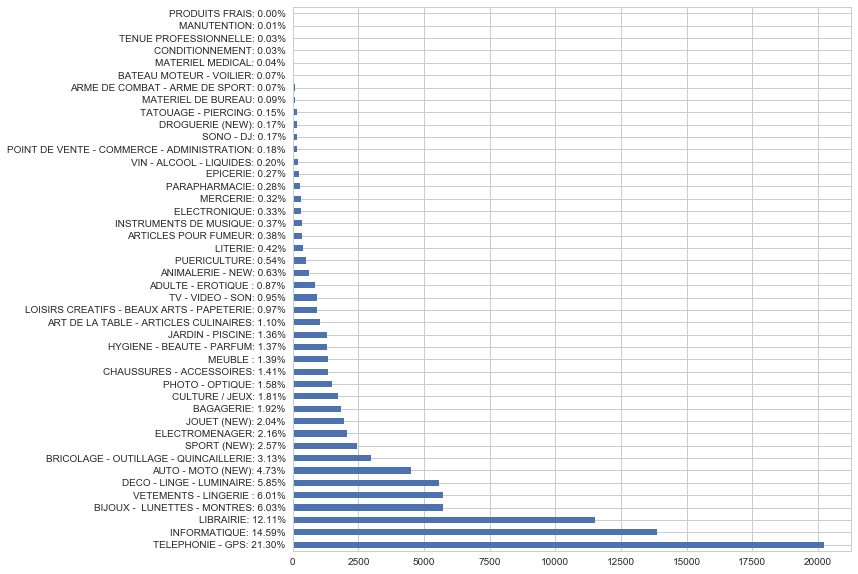

In [7]:
#Count occurence of each Categorie
data_count = data_train["Categorie1"].value_counts()
#Rename index to add percentage
new_index = [k+ ": %.2f%%" %(v*100/N_train) for k,v in data_count.iteritems()]
data_count.index = new_index

fig=plt.figure(figsize= (10,10))
ax = fig.add_subplot(1,1,1)
data_count.plot.barh(logx = False)
plt.show()

**Q** Que peut-on dire sur la distribution de ces classes?

### Sauvegarde des données

On sauvegarde dans des csv les fichiers `train` et `validation` afin que ces mêmes fichiers soit ré-utilisés plus tard dans d'autre calepin

In [8]:
data_valid.to_csv("data/cdiscount_valid.csv", index=False)
data_train.to_csv("data/cdiscount_train_subset.csv", index=False)

##  Nettoyage des données

Afin de limiter la dimension de l'espace des variables ou *features* (i.e les mots présents dans le document), tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:

* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### Exemple 

Observons dans un premier temps l'effet de ces différentes étapes sur un  exemple. 

**Ligne Originale**

In [9]:
i = 0
description = data_train.Description.values[i]
print("Original Description : " + description)

Original Description : Batterie Originale B100AE pour SAMSUNG GT-S7220 Galaxy Ace 3 - 3,7v / Li-ion / 1500 mAh Batterie de qualité supérieure, idéale si l’autonomie de votre portable est réduite, s’…Voir la présentation


**Suppression des posibles balises HTML dans la description**

Les descriptions produits étant parfois extraites d'autres sites commerçant, des balises HTML peuvent être incluts dans la description. 
La librairie 'BeautifulSoup' permet de supprimer ces balises


In [10]:
from bs4 import BeautifulSoup #Nettoyage d'HTML
txt = BeautifulSoup(description,"html.parser",from_encoding='utf-8').get_text()
print(txt)

Batterie Originale B100AE pour SAMSUNG GT-S7220 Galaxy Ace 3 - 3,7v / Li-ion / 1500 mAh Batterie de qualité supérieure, idéale si l’autonomie de votre portable est réduite, s’…Voir la présentation


**Conversion du texte en minuscule**

Certaines mots peuvent être écrits en majuscule dans les descriptions textes, cela à pour conséquence de dupliquer le nombre de features et une perte d'information.

In [11]:
txt = txt.lower()
print(txt)

batterie originale b100ae pour samsung gt-s7220 galaxy ace 3 - 3,7v / li-ion / 1500 mah batterie de qualité supérieure, idéale si l’autonomie de votre portable est réduite, s’…voir la présentation


**Remplacement de caractères spéciaux**

Certains caractères spéciaux sont supprimés comme par exemple :

* `\u2026`: `…`
* `\u00a0`: `NO-BREAK SPACE`

Cette liste est non exhaustive et peut être etayée en fonction du jeu de donées étudié, de l'objectif souhaité ou encore du résultat de l'étude explorative.

In [12]:
txt = txt.replace(u'\u2026','.')    
txt = txt.replace(u'\u00a0',' ')
print(txt)

batterie originale b100ae pour samsung gt-s7220 galaxy ace 3 - 3,7v / li-ion / 1500 mah batterie de qualité supérieure, idéale si l’autonomie de votre portable est réduite, s’.voir la présentation


**Suppression des accents**

In [13]:
txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
print(txt)

batterie originale b100ae pour samsung gt-s7220 galaxy ace 3 - 3,7v / li-ion / 1500 mah batterie de qualite superieure, ideale si lautonomie de votre portable est reduite, s.voir la presentation


**Supprime les caractères qui ne sont ne sont pas des lettres minuscules**

Une fois ces premières étapes passées, on supprime tous les caractères qui sont pas des lettres minusculres, c'est à dire les signes de ponctuation, les caractères numériques etc...

In [14]:
txt = re.sub('[^a-z_]', ' ', txt)
print(txt)

batterie originale b   ae pour samsung gt s     galaxy ace        v   li ion        mah batterie de qualite superieure  ideale si lautonomie de votre portable est reduite  s voir la presentation


**Remplace la description par une liste de mots (tokens), supprime les mots de moins de 2 lettres ainsi que les stopwords**

On va supprimer maintenant tous les mots considérés comme "non-informatif". Par exemple : "le", "la", "de" ...
Des listes contenants ces mots sont proposés dans des libraires tels que *nltk* ou encore *lucène*.

In [15]:
## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords =open("data/lucene_stopwords.txt","r").read().split(",") #En local
## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

stopwords[:10]

['me', 'pour', 'ô', 'en', 'excepté', 'même', 'te', 'elle', 'certaine', 'avons']

On applique également la suppression des accents à cette liste

In [16]:
stopwords = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwords]
stopwords[:10]

['me', 'pour', 'o', 'en', 'excepte', 'meme', 'te', 'elle', 'certaine', 'avons']

Enfin on crée des *tokens*, liste de mots dans la description produit, en supprimant les éléments de notre description produit qui sont présent dans la liste de stopword.

In [17]:
tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
remove_words = [w for w in txt.split() if (len(w)<2) or (w in stopwords)]

print(tokens)
print(remove_words)

['batterie', 'originale', 'samsung', 'galaxy', 'ace', 'ion', 'mah', 'batterie', 'qualite', 'superieure', 'ideale', 'lautonomie', 'portable', 'reduite', 'voir', 'presentation']
['b', 'pour', 's', 'v', 'de', 'si', 'de', 'votre', 'est', 's', 'la']


**Racinisation (Stem) chaque tokens**

Pour chaque mot de notre liste de token, on va ramener ce mot à sa racine au sens de l'algorithme de Snowball présent dans la librairie **nltk**. 

Cette liste de mots néttoyé et racinisé va constitué les *features* de cette description produits.

In [18]:
## Fonction de setmming de stemming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')
tokens_stem = [stemmer.stem(token) for token in tokens]
print(tokens_stem)

['batter', 'original', 'samsung', 'galaxy', 'ace', 'ion', 'mah', 'batter', 'qualit', 'superieur', 'ideal', 'lautonom', 'portabl', 'reduit', 'voir', 'present']


### Fonction de nettoyage de texte

On définit une fonction `clean-txt` qui prend en entrée un texte de description produit et qui retourne le texte nettoyé en appliquant successivement les étapes présentés précedemment. 

On définit également une fonction `clean_marque` qui contient signifcativement moins d'étape de nettoyage. 

In [19]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text()
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens_stem = [stemmer.stem(token) for token in tokens]
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens), " ".join(tokens_stem)

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

Applique le nettoyage sur toutes les lignes de la DataFrame et créé deux nouvelles Dataframe (avant et sans l'étape de racinisation).

In [20]:

# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Description', 'Libelle', 'Marque']):

    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    clean_stem_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Marque":
            array_clean = np.array(list(map(clean_marque,column)))
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean)
        else:
            A = np.array(list(map(clean_txt,column)))
            array_clean = A[:,0]
            array_clean_stem = A[:,1]
            clean_list.append(array_clean)
            clean_stem_list.append(array_clean_stem)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    
    array_clean_stem = np.array(clean_stem_list).T
    data_clean_stem = pd.DataFrame(array_clean_stem, columns = column_names)
    return data_clean, data_clean_stem

### Nettoyage des DataFrames

In [21]:
# Take approximately 2 minutes fors 100.000 rows
warnings.filterwarnings("ignore")
data_valid_clean, data_valid_clean_stem = clean_df(data_valid)

Start Clean 5000 lines
Cleaning time: 4 secondes


In [22]:
warnings.filterwarnings("ignore")
data_train_clean, data_train_clean_stem = clean_df(data_train)

Start Clean 95000 lines
Cleaning time: 89 secondes


Affiche les 5 premières lignes de la DataFrame d'apprentissage après nettoyage.

In [23]:
data_train_clean.head(5)

,Description,Libelle,Marque
0,batterie originale samsung galaxy ace ion mah ...,batterie originale samsung,samsung
1,coque souple rose wiko iggy motif drapeau nebr...,coque souple rose wiko iggy motif drapeau,muzzano
2,motorola oreillette motorola oreillette blueto...,motorola oreillette,motorola
3,collectif editions harrap,harrap petit dictionnaire,
4,interface commande volant mercedes classe inte...,interface commande volant mercedes classe,aucune


In [24]:
data_train_clean_stem.head(5)

,Description,Libelle,Marque
0,batter original samsung galaxy ace ion mah bat...,batter original samsung,samsung
1,coqu soupl ros wiko iggy motif drapeau nebrask...,coqu soupl ros wiko iggy motif drapeau,muzzano
2,motorol oreillet motorol oreillet bluetooth ch...,motorol oreillet,motorola
3,collect edit harrap,harrap pet dictionnair,
4,interfac command vol merced class interfac com...,interfac command vol merced class,aucune


Taille du dictionnaire de mots pour le dataset avant et après la racinisation.

In [25]:
concatenate_text = " ".join(data_train["Description"].values)
list_of_word = concatenate_text.split(" ")
N = len(set(list_of_word))
print(N)

211605


In [26]:
concatenate_text = " ".join(data_train_clean["Description"].values)
list_of_word = concatenate_text.split(" ")
N = len(set(list_of_word))
print(N)

72841


In [27]:
concatenate_text = " ".join(data_train_clean_stem["Description"].values)
list_of_word_stem = concatenate_text.split(" ")
N = len(set(list_of_word_stem))
print(N)

56669


### Wordcloud

Les représentations *Wordcloud* permettent des représentations de l'ensemble des mots d'un corpus de documents. Dans cette représentation plus un mot apparait de manière fréquent dans le corpus, plus sa taille sera grande dans la représentation du corpus.



In [28]:
from wordcloud import WordCloud

In [29]:
A=WordCloud(background_color="black")
A.generate_from_text?

Signature: A.generate_from_text(text)
Docstring:
Generate wordcloud from text.

The input "text" is expected to be a natural text. If you pass a sorted
list of words, words will appear in your output twice. To remove this
duplication, set ``collocations=False``.

Calls process_text and generate_from_frequencies.

..versionchanged:: 1.2.2
    Argument of generate_from_frequencies() is not return of
    process_text() any more.

Returns
-------
self
File:      ~/anaconda/envs/TPInsa/lib/python3.5/site-packages/wordcloud/wordcloud.py
Type:      method


Wordcloud de l'ensemble des description à l'état brut.

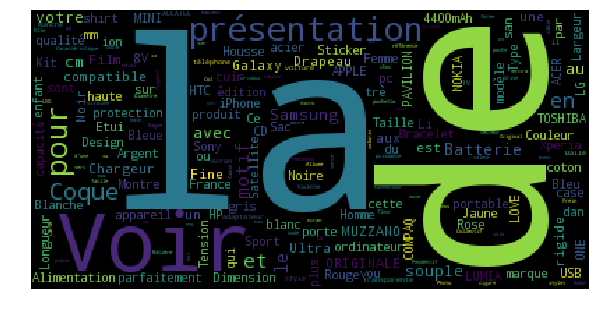

In [30]:
all_descr = " ".join(data_valid.Description.values)
wordcloud_word = WordCloud(background_color="black", collocations=False).generate_from_text(all_descr)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

Wordcloud après racinisation et nettoyage

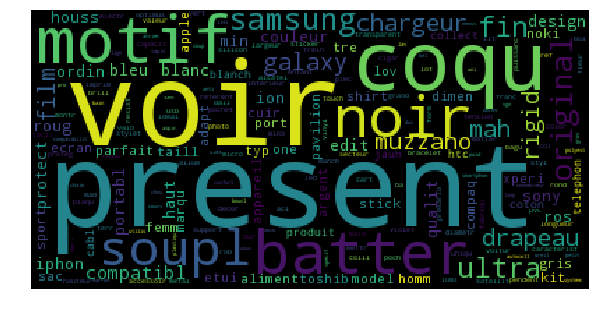

In [31]:
all_descr_clean_stem = " ".join(data_valid_clean_stem.Description.values)
wordcloud_word = WordCloud(background_color="black", collocations=False).generate_from_text(all_descr_clean_stem)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

Vous pouvez observer que les mots "voir et "present" sont les plus représentés. Cela est du au fait que la pluspart des descriptions se terminent par "Voir la présentation". C'est deux mots ne sont donc pas informatif car présent dans beaucoup de catégorie différente. C'est une bon exemple de *stopword* propre à un problème spécifique.

**Exercice** Ajouter les mots `voir`et `présentation`à la liste des stopwords plus hauts et refaites tourner le nettoyage.

**Exercice** Générer les wordcloud par catégorie pour 3 catégories de votre choix.

## Sauvegarde des jeux de données nettoyés dans des fichiers csv.

In [32]:
data_valid_clean.to_csv("data/cdiscount_valid_clean.csv", index=False)
data_train_clean.to_csv("data/cdiscount_train_clean.csv", index=False)

data_valid_clean_stem.to_csv("data/cdiscount_valid_clean_stem.csv", index=False)
data_train_clean_stem.to_csv("data/cdiscount_train_clean_stem.csv", index=False)